In [1]:
# from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from datetime import datetime as dt

import statsmodels.api as sm
import scipy.stats as sps

pd.options.mode.chained_assignment = None  # default='warn'
%load_ext autoreload
%autoreload 2

In [60]:
from utils_plot import set_plt_settings, plot_ts_model
from utils_data import NODES, PATH_DATA, make_analysis_dataset
from utils_mdp import R, train_valueit_model, train_valueit_modelL, test_valueit_model, get_charge
from utils_battery import discretize_e_states, get_efficiency
from utils_cv import train_test_split, crossval_model

set_plt_settings()

In [3]:
PATH_RESULTS = f'{PATH_DATA}results/'

# 0. Make analytic datasets

In [4]:
node = NODES[0]
# read in data
df = make_analysis_dataset(nodes=[node])

# set columns
# set columns
mark_cols = [col for col in df.columns if col.startswith(('lmp_rt_m'))] + ['lmp_da']
node_cols = [col for col in df.columns if col.startswith(('node'))] 
hour_cols = [col for col in df.columns if col.startswith(('h_'))]

['caiso_th_np15_gen-apnd']


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


['caiso_th_np15_gen-apnd']


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.83it/s]


In [41]:
# col params
XOLS_cols = mark_cols + hour_cols + node_cols + ['lmp_rt_m1_rolling']
Xvi_cols = ['lmp_rt_m1', 'lmp_rt_m2', 'lmp_rt_m1_rolling', 'lmp_da'] + hour_cols
y_col = 'lmp_rt'
group_cols = ['year']

# state params
S = 3000
kmax=50

In [42]:
# battery params
b_params = {'dur':4, 'capacity':200}
b_params['efficiency'] = get_efficiency(b_params['dur'])

In [43]:
df['lmp_rt_m1_rolling']  = df.lmp_rt_m1.ewm(alpha=0.5).mean()
X_tt, y_tt, g_tt, X_val, y_val = train_test_split(df, XOLS_cols, y_col, group_cols, yr_val=2022)

In [44]:
st_e = discretize_e_states(b_params)

In [52]:
e_c = 200

In [46]:
st_e.astype(int)

array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600,
       650, 700, 750, 800])

In [49]:
# one hot encode charge
colnames = []
for c in st_e.astype(int):
    colnames += [f'e{c}']
    for col in [col for col in X_tt[Xvi_cols].columns if not col.startswith('e_')]:
        colnames += [f'{col}_x_e{c}']

newcols = pd.DataFrame(np.zeros([len(X_tt), len(colnames)]), columns=colnames)
X_tt = pd.concat([X_tt[Xvi_cols].reset_index(drop=True), newcols], axis=1)

In [53]:
# update columns based on charge
X_tt[f'e{e_c}']
for col in [col for col in X_tt.columns if not col.startswith('e_')]:
    X_tt[f'{col}_x_e{e_c}'] = X_tt[f'{col}']

/var/folders/mw/dy3m3wg11js6x91fwng5ptdw0000gn/T/ipykernel_21176/2038752742.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_tt[f'{col}_x_e{e_c}'] = X_tt[f'{col}']
/var/folders/mw/dy3m3wg11js6x91fwng5ptdw0000gn/T/ipykernel_21176/2038752742.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_tt[f'{col}_x_e{e_c}'] = X_tt[f'{col}']
/var/folders/mw/dy3m3wg11js6x91fwng5ptdw0000gn/T/ipykernel_21176/2038752742.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many tim

In [522]:
t = [0]
svect = (np.hstack([X_tt.iloc[t].values, y_tt[t].reshape(-1,1), np.repeat(e + charge, len(t)).reshape(-1,1)]))

In [531]:
X_tt.shape

(70073, 70)

# 1. Model-based value iteration for 4hr battery

In [515]:
# battery params
b_params = {'dur':4, 'capacity':200}
b_params['efficiency'] = get_efficiency(b_params['dur'])

In [516]:
# start from previous hyperparam tuning
summ = pd.read_csv(f'{PATH_RESULTS}hptune_summ_{node.lower()}_{b_params["dur"]}.csv')
summmean = summ.groupby(['w_roll', 'w_e', 'ma']).mean().reset_index()

# store best
opt_idx = summmean.cumrev.argmax()
hp_optimal = summmean.iloc[opt_idx].values[:3]
print('best params:', hp_optimal, f'(mean cumrev={summmean.cumrev.max()})')

best params: [ 18.75 -18.     0.5 ] (mean cumrev=202307.24359527032)


In [514]:
# wr*ws, wr*(1-ws)
summ

,cumrev,mean_storage,downtime,w_roll,w_e,ma
0,1.358341e+05,8.739333,0.974427,25.00,-24.00,0.9
1,2.408546e+05,8.083115,0.979221,25.00,-24.00,0.9
2,1.365728e+05,8.750749,0.974570,25.00,-24.00,0.5
3,2.413346e+05,8.026030,0.979164,25.00,-24.00,0.5
4,1.073780e+05,6.815652,0.985301,5.00,-4.00,0.9
5,2.193462e+05,7.186893,0.983617,5.00,-4.00,0.9
6,1.086011e+05,6.821360,0.985301,5.00,-4.00,0.5
7,2.127705e+05,7.135518,0.983674,5.00,-4.00,0.5
8,9.773696e+04,6.381825,0.992522,0.00,1.00,0.9
9,2.090140e+05,6.884348,0.989211,0.00,1.00,0.9


In [54]:
hp_optimal = [0.75, 100, 0.9]

In [55]:
# evaluate on full dataset
df['lmp_rt_m1_rolling']  = df.lmp_rt_m1.ewm(alpha=hp_optimal[2]).mean()

In [72]:
X_tt, y_tt, g_tt, X_val, y_val = train_test_split(df, XOLS_cols, y_col, group_cols, yr_val=2022)

# Train on training data
Utheta, U_theta_log = train_valueit_model(X_tt[Xvi_cols], y_tt, hp_optimal[:2], b_params, R, int(len(y_tt)/10), kmax, verbose=True)

train: 100%|████████████████████████████████████| 50/50 [00:17<00:00,  2.80it/s]


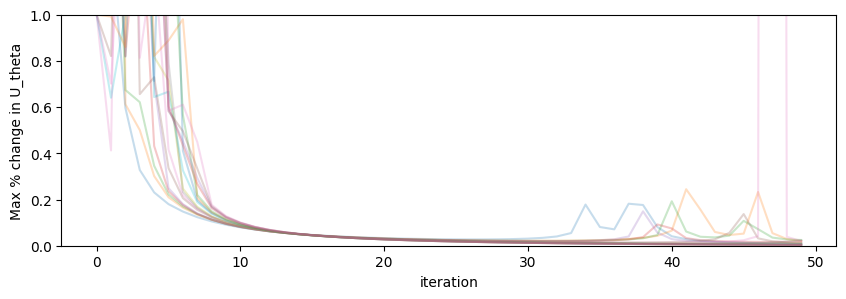

In [73]:
# look at convergence in U_theta
plt.figure(figsize=(10, 3))
for i, e in enumerate(discretize_e_states(b_params)):
    plt.plot(U_theta_log[:, i], alpha=0.25, label=f'{int(e)}MWh')
    
# plt.legend()
plt.ylabel('Max % change in U_theta')
plt.xlabel('iteration')
plt.ylim((0, 1))
plt.show()

In [74]:
# evaluate on hold-out year (2022)
ymodel = sm.OLS(endog=y_tt, exog=X_tt).fit(disp=0)
yhat_val = ymodel.predict(X_val).values
ace, revenue = test_valueit_model(X_val[Xvi_cols], y_val, yhat_val, Utheta, hp_optimal[:2], b_params, verbose=True)

test: 100%|██████████████████████████████| 35035/35035 [01:16<00:00, 458.95it/s]


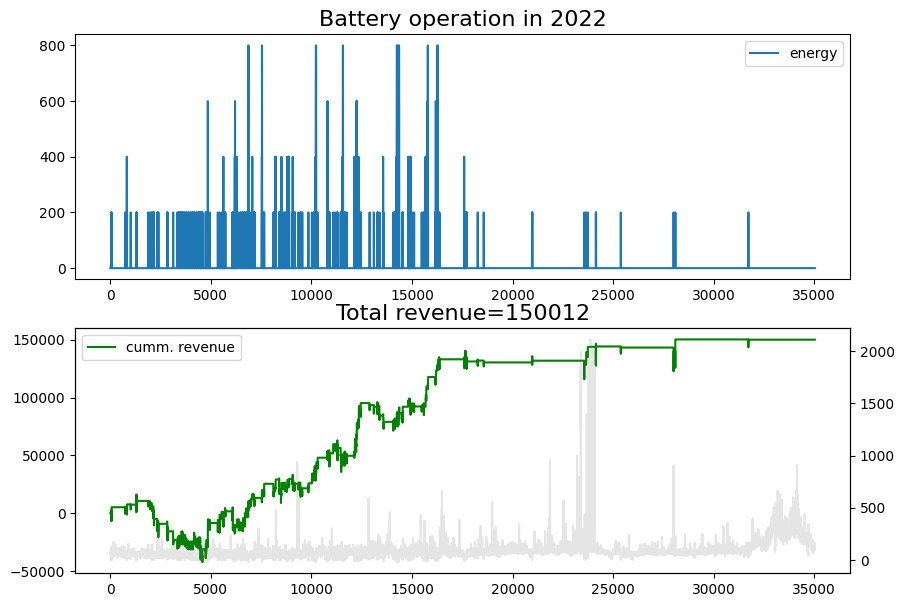

In [75]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 7))
ax1r = ax[1].twinx()
ax[0].plot(ace[2], label='energy')
ax1r.plot(y_val, color='grey', alpha=0.2)
ax[1].plot(np.cumsum(revenue), label='cumm. revenue', color='green')
ax[0].legend()
ax[1].legend()
ax[0].set_title('Battery operation in 2022')
ax[1].set_title(f'Total revenue={int(revenue.sum())}')
plt.show()

In [36]:
# save Utheta
pd.DataFrame(Utheta).to_csv(f'{PATH_RESULTS}Utheta_N{node.lower()}_D{b_params["dur"]}_R{int(revenue.sum())}.csv', index=False)

### 1.4.b Evaluate on hold-out data

### 100hr

In [42]:
ymodel = sm.OLS(endog=y_tt, exog=X_tt).fit(disp=0)
yhat_val = ymodel.predict(X_val).values
ace, revenue = test_valueit_model(X_val, y_val, yhat_val, Utheta, hp_optimal[:2], b_params, verbose=True)

test: 100%|██████████████████████████████| 35035/35035 [01:10<00:00, 497.42it/s]


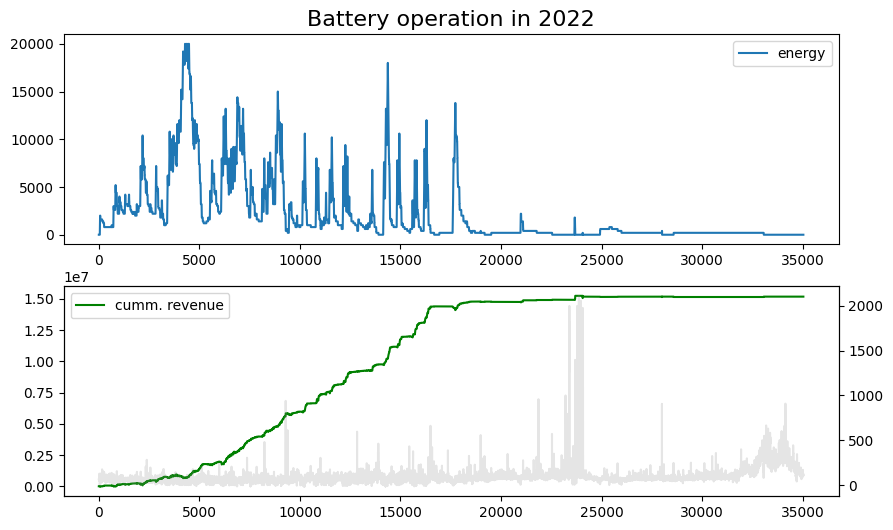

In [43]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 6))
ax1r = ax[1].twinx()
ax[0].plot(ace[2], label='energy')
ax1r.plot(y_val, color='grey', alpha=0.2)
ax[1].plot(np.cumsum(revenue), label='cumm. revenue', color='green')
ax[0].legend()
ax[1].legend()
ax[0].set_title('Battery operation in 2022')
plt.show()

### 4hr